In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys,os,glob
import pyslha
import itertools
from scipy.interpolate import  griddata
from importlib.machinery import SourceFileLoader

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

## Get SModelS and SLHA data

In [2]:
slhaDir = './TRPVM1jjj_slha/'
resultsDir = './TRPVM1jjj_results/'

In [3]:
xyz = []
for f in glob.glob(resultsDir+'/*.py'):
    
    smodelsDict = SourceFileLoader('smodelsOutput', f).load_module().smodelsOutput
    rcomb = 0.0
    r = 0.0
    if 'ExptRes' in smodelsDict:
        rvalues = []
        for res in smodelsDict['ExptRes']:
            if res['dataType'] == 'combined':
                rcomb = res['r']
            else:
                rvalues.append(res['r'])
        r = max(rvalues)
    
    slhaFile = os.path.basename(smodelsDict['OutputStatus']['input file'])
    slhaData = pyslha.readSLHAFile(os.path.join(slhaDir,slhaFile))
    mLLP = slhaData.blocks['MASS'][1000022]
    tauLLP = (6.582e-16)/slhaData.decays[1000022].totalwidth
    xyz.append([tauLLP,mLLP,r,rcomb])
xyz = np.array(xyz)

In [4]:
atlasCurve = np.genfromtxt('../orig/excl_ewk_obs_nominal.csv',delimiter=',',comments='#')

In [5]:
x = xyz[:,0]
y = xyz[:,1]
z = xyz[:,3]
nx = 100
ny = 100
xnew = np.logspace(np.log(x.min()),np.log(x.max()),nx)
ynew = np.linspace(y.min(),y.max(),ny)
xi = np.array([list(v) for v in itertools.product(xnew,ynew)])
znew = griddata(list(zip(x,y)),z,xi=xi, method='linear',fill_value=np.nan)
znew = np.reshape(znew,(len(xnew),len(ynew)))
xnew,ynew  = np.meshgrid(xnew,ynew,indexing='ij')

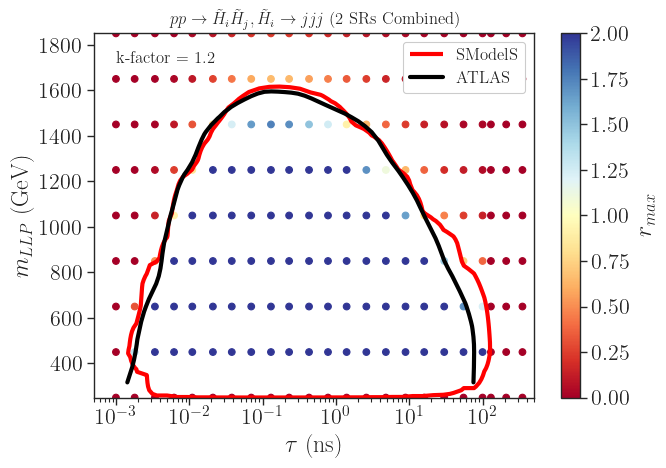

In [6]:
kfactor = 1.2
fig = plt.figure(figsize=(7,5))
CS = plt.contour(xnew,ynew,znew, [1./kfactor],linewidths=3,colors='red')
h,_ = CS.legend_elements()
plt.scatter(x,y,c=z,cmap=cm,vmin=0,vmax=2)
plt.colorbar(label=r'$r_{max}$')
atlasC = plt.plot(atlasCurve[:,0],atlasCurve[:,1],linewidth=3,c='black',linestyle='solid',label='ATLAS')
plt.xscale('log')
plt.text(0.05,0.92,'k-factor = %1.1f' %kfactor, fontsize=12,
         transform=plt.gca().transAxes)
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'$m_{LLP}$ (GeV)')
plt.legend([h[0],atlasC[0]], ['SModelS','ATLAS'],loc='upper right',framealpha=1.0,fontsize=12)
plt.xlim(5e-4,5e2)
plt.title(r'$p p \to \tilde{H}_i \tilde{H}_j, \tilde{H}_i \to jjj$ (2 SRs Combined)',fontsize=12)
plt.tight_layout()
plt.savefig('TRPVM1jjj.png')
plt.show()